In [1]:
# Importing libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import numpy as np


mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['axes.grid'] = False

In [6]:
df = pd.read_csv('Weather.csv', parse_dates=True)

df.head()

,dt,dt_iso,timezone,city_name,lat,lon,temp,visibility,dew_point,feels_like,...,wind_gust,rain_1h,rain_3h,snow_1h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,1199145600,1/1/2008 0:00,0,Leicester,52.636878,-1.139759,7.38,NaN,6.79,5.53,...,NaN,NaN,NaN,NaN,NaN,90,804,Clouds,overcast clouds,04n
1,1199149200,1/1/2008 1:00,0,Leicester,52.636878,-1.139759,6.49,NaN,6.05,4.51,...,NaN,NaN,NaN,NaN,NaN,96,804,Clouds,overcast clouds,04n
2,1199152800,1/1/2008 2:00,0,Leicester,52.636878,-1.139759,6.45,NaN,6.01,4.54,...,NaN,NaN,NaN,NaN,NaN,98,804,Clouds,overcast clouds,04n
3,1199156400,1/1/2008 3:00,0,Leicester,52.636878,-1.139759,6.74,NaN,6.45,5.05,...,NaN,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n
4,1199160000,1/1/2008 4:00,0,Leicester,52.636878,-1.139759,6.64,NaN,6.35,5.08,...,NaN,NaN,NaN,NaN,NaN,100,804,Clouds,overcast clouds,04n


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124176 entries, 0 to 124175
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   dt                   124176 non-null  int64  
 1   dt_iso               124176 non-null  object 
 2   timezone             124176 non-null  int64  
 3   city_name            124176 non-null  object 
 4   lat                  124176 non-null  float64
 5   lon                  124176 non-null  float64
 6   temp                 124176 non-null  float64
 7   visibility           0 non-null       float64
 8   dew_point            124176 non-null  float64
 9   feels_like           124176 non-null  float64
 10  temp_min             124176 non-null  float64
 11  temp_max             124176 non-null  float64
 12  pressure             124176 non-null  int64  
 13  sea_level            0 non-null       float64
 14  grnd_level           0 non-null       float64
 15  humidity         

In [13]:
features = ['dt_iso', 'temp', 'pressure', 'wind_speed']

df1 = df[features]
df1 = df1.rename(columns={'dt_iso':'Date Time'})
df1['Date Time'] = pd.to_datetime(df1['Date Time'])
df1.head()

,Date Time,temp,pressure,wind_speed
0,2008-01-01 00:00:00,7.38,1026,2.76
1,2008-01-01 01:00:00,6.49,1026,2.70
2,2008-01-01 02:00:00,6.45,1025,2.60
3,2008-01-01 03:00:00,6.74,1025,2.39
4,2008-01-01 04:00:00,6.64,1024,2.22


In [14]:
## using univariate feature(Only temperature for given time)

uni_data = df1['temp']
uni_data.index = df1['Date Time']
uni_data

Date Time
2008-01-01 00:00:00    7.38
2008-01-01 01:00:00    6.49
2008-01-01 02:00:00    6.45
2008-01-01 03:00:00    6.74
2008-01-01 04:00:00    6.64
                       ... 
2022-03-01 19:00:00    6.67
2022-03-01 20:00:00    6.30
2022-03-01 21:00:00    6.10
2022-03-01 22:00:00    5.87
2022-03-01 23:00:00    5.63
Name: temp, Length: 124176, dtype: float64

<AxesSubplot:xlabel='Date Time'>

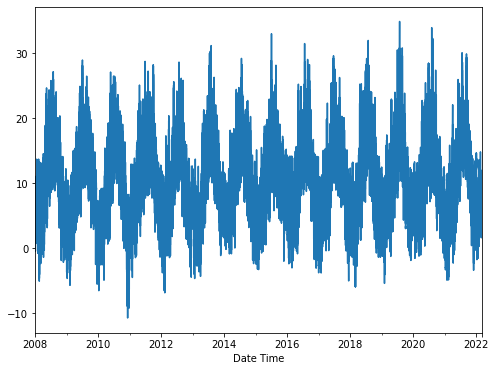

In [15]:
uni_data.plot()

In [16]:
uni_data = uni_data.values

In [17]:
## train test split for simple time series moving window average
train_split = 120000
tf.random.set_seed(13)

### standardize data
uni_data_mean = uni_data[:train_split].mean()
uni_data_std = uni_data[:train_split].std()
uni_data  = (uni_data - uni_data_mean)/ uni_data_std

print(np.ravel(uni_data))

[-0.51812837 -0.66814197 -0.67488416 ... -0.73387827 -0.77264583
 -0.81309894]


In [21]:
## utility functions

## funtion to create data for univariate forecasting

def univariate_data(dataset, start_idx , end_idx , history_size, target_size):
  data = []
  labels = []
  start_idx  = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx):
    idxs = range(i-history_size , i)
    data.append(np.reshape(dataset[idxs] , (history_size, 1))) ### reshape data
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

uni_data_history = 24   ## last 20 values
uni_data_future = 1     ## future data

x_train_uni , y_train_uni = univariate_data(np.ravel(uni_data) , 0 , train_split , uni_data_history , uni_data_future)

x_val_uni , y_val_uni = univariate_data(np.ravel(uni_data) , train_split , None ,uni_data_history , uni_data_future)

In [22]:
print(x_train_uni.shape , y_train_uni.shape)
print(x_val_uni.shape , y_val_uni.shape)

(119976, 24, 1) (119976,)
(4151, 24, 1) (4151,)


In [23]:
print('Single window of history data' , x_train_uni[0])

print('Target Temperature to predict ' , y_train_uni[0])

Single window of history data [[-0.51812837]
 [-0.66814197]
 [-0.67488416]
 [-0.62600332]
 [-0.64285878]
 [-0.64117324]
 [-0.63780214]
 [-0.73219272]
 [-0.64285878]
 [-0.63274551]
 [-0.59903458]
 [-0.57880803]
 [-0.47430417]
 [-0.45239207]
 [-0.43722216]
 [-0.41699561]
 [-0.43385107]
 [-0.56700921]
 [-0.58217912]
 [-0.59734904]
 [-0.58892131]
 [-0.71365172]
 [-0.70859508]
 [-0.70353844]]
Target Temperature to predict  -0.7069095332732184


<module 'matplotlib.pyplot' from 'C:\\Users\\moham\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

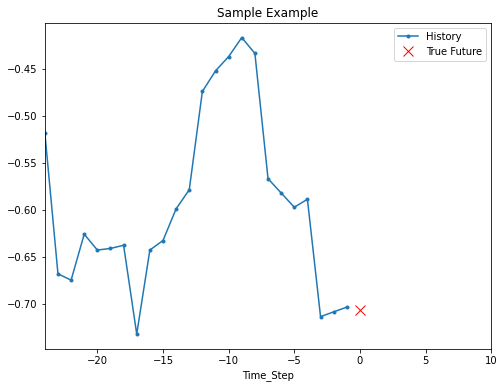

In [24]:
### fucntion to create time steps
def create_time_steps(length):
  return list(range(-length,0))

### function to plot time series data

def plot_time_series(plot_data, delta , title):
  labels = ["History" , 'True Future' , 'Model Predcited']
  marker = ['.-' , 'rx' , 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])

  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i , x in enumerate(plot_data):
    if i :
      plt.plot(future , plot_data[i] , marker[i], markersize = 10 , label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5) *2])

  plt.xlabel('Time_Step')
  return plt

plot_time_series([x_train_uni[0] , y_train_uni[0]] , 0 , 'Sample Example')

<module 'matplotlib.pyplot' from 'C:\\Users\\moham\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

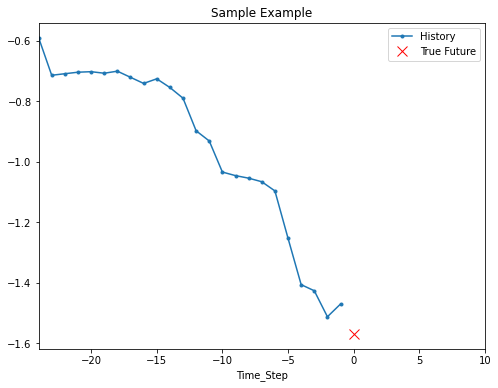

In [25]:
i = 20
plot_time_series([x_train_uni[i], y_train_uni[i]] , 0 , 'Sample Example')

In [26]:
### Moving window average

def MWA(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\moham\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

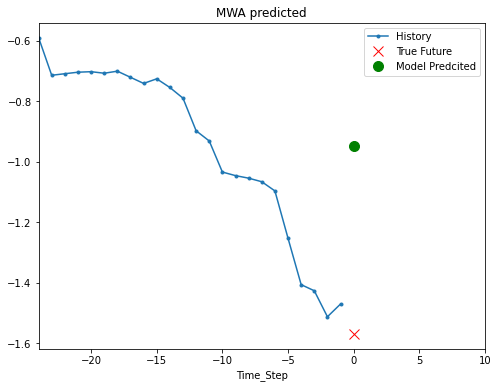

In [27]:
i = 20
plot_time_series([x_train_uni[i] , y_train_uni[i] , MWA(x_train_uni[i])] , 0 , 'MWA predicted')

Univariate time-series forecasting

- Only single feature as temperature(historical data)
- Task: Given last 20 observations(history) , predict next temperature value

In [28]:
## prepare tensorflow dataset
batch_size = 256
buffer_size = 10000

train_uni = tf.data.Dataset.from_tensor_slices((x_train_uni , y_train_uni))
train_uni = train_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_uni = tf.data.Dataset.from_tensor_slices((x_val_uni , y_val_uni))
val_uni = val_uni.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_uni)
print(val_uni)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 24, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 24, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [29]:
## Define LSTM model 

lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(16 , input_shape = x_train_uni.shape[-2:]), tf.keras.layers.Dense(1)])

lstm_model.compile(optimizer = 'adam', loss = 'mae')

steps = 200

EPOCHS =10

lstm_model.fit(train_uni , epochs = EPOCHS, steps_per_epoch = steps, validation_data = val_uni, validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 4s 11ms/step - loss: 0.3574 - val_loss: 0.1802
Epoch 2/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1695 - val_loss: 0.1257
Epoch 3/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1327 - val_loss: 0.1170
Epoch 4/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1333 - val_loss: 0.1098
Epoch 5/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1267 - val_loss: 0.1141
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1260 - val_loss: 0.1063
Epoch 7/10
200/200 [==============================] - 2s 8ms/step - loss: 0.1283 - val_loss: 0.1047
Epoch 8/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1208 - val_loss: 0.1055
Epoch 9/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1293 - val_loss: 0.1057
Epoch 10/10
200/200 [==============================] - 2s 9ms/step - loss: 0.1194 - val_loss: 0.104

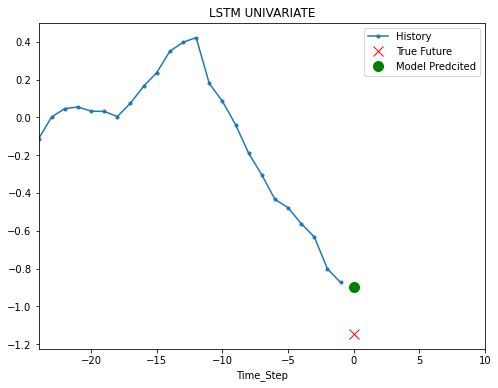

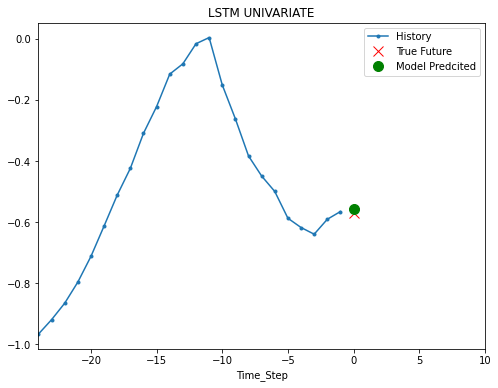

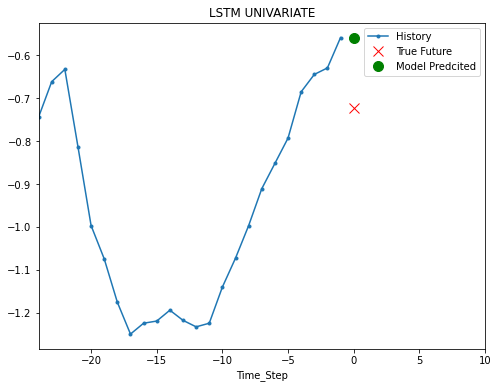

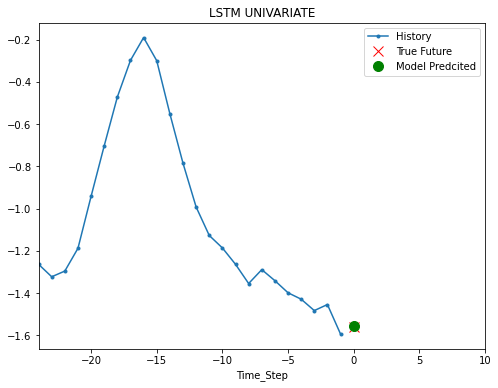

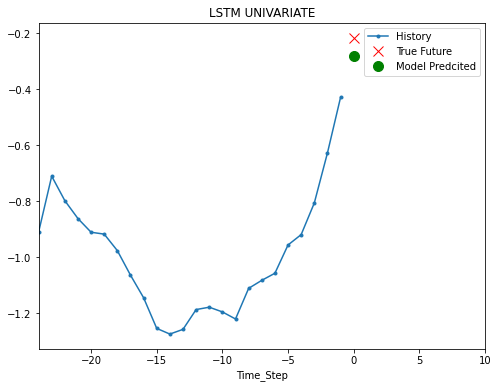

In [30]:
for i , j in val_uni.take(5):
  plot = plot_time_series([i[0].numpy() , j[0].numpy() , lstm_model.predict(i)[0]] ,0 , 'LSTM UNIVARIATE')
  plot.show()

Multivariate and Single step Forecasting

- Task: Given 3 features(temp , pressure , and density) at each time step can we predict the temp in future at single time step

In [31]:
## features 

features_3 = ['temp', 'pressure', 'wind_speed']

features = df1[features_3]
features.index = df1['Date Time']
features.head()

,temp,pressure,wind_speed
Date Time,,,
2008-01-01 00:00:00,7.38,1026,2.76
2008-01-01 01:00:00,6.49,1026,2.70
2008-01-01 02:00:00,6.45,1025,2.60
2008-01-01 03:00:00,6.74,1025,2.39
2008-01-01 04:00:00,6.64,1024,2.22


array([<AxesSubplot:xlabel='Date Time'>, <AxesSubplot:xlabel='Date Time'>,
       <AxesSubplot:xlabel='Date Time'>], dtype=object)

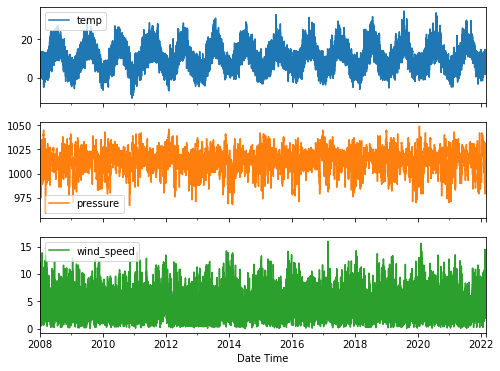

In [32]:
features.plot(subplots=True)

In [33]:
### standardize data
dataset = features.values

data_mean = dataset[:train_split].mean(axis =0)

data_std = dataset[:train_split].std(axis = 0)

dataset = (dataset - data_mean)/data_std

In [34]:
### create mutlivariate data

def mutlivariate_data(dataset , target , start_idx , end_idx , history_size , target_size,
                      step ,  single_step = False):
  data = []
  labels = []
  start_idx = start_idx + history_size
  if end_idx is None:
    end_idx = len(dataset)- target_size
  for i in range(start_idx , end_idx ):
    idxs = range(i-history_size, i, step) ### using step
    data.append(dataset[idxs])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data) , np.array(labels)

In [35]:
### generate multivariate data

history = 720
future_target = 24
STEP = 6

x_train_ss , y_train_ss = mutlivariate_data(dataset , dataset[:, 1], 0, train_split, history,
                                            future_target, STEP , single_step = True)

x_val_ss , y_val_ss = mutlivariate_data(dataset , dataset[:,1] , train_split , None , history ,
                                        future_target, STEP, single_step = True)

print(x_train_ss.shape , y_train_ss.shape)

(119280, 120, 3) (119280,)


In [36]:
## tensorflow dataset

train_ss = tf.data.Dataset.from_tensor_slices((x_train_ss, y_train_ss))
train_ss = train_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_ss = tf.data.Dataset.from_tensor_slices((x_val_ss, y_val_ss))
val_ss = val_ss.cache().shuffle(buffer_size).batch(batch_size).repeat()

print(train_ss)
print(val_ss)

<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>
<RepeatDataset element_spec=(TensorSpec(shape=(None, 120, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>


In [37]:
### Modelling using LSTM

single_step_model = tf.keras.models.Sequential()

single_step_model.add(tf.keras.layers.LSTM(32, input_shape = x_train_ss.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mae')
single_step_model_history = single_step_model.fit(train_ss, epochs = EPOCHS , 
                                                  steps_per_epoch =steps, validation_data = val_ss,
                                                  validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 15s 67ms/step - loss: 0.5700 - val_loss: 0.6705
Epoch 2/10
200/200 [==============================] - 14s 68ms/step - loss: 0.5276 - val_loss: 0.6499
Epoch 3/10
200/200 [==============================] - 14s 68ms/step - loss: 0.5000 - val_loss: 0.6522
Epoch 4/10
200/200 [==============================] - 14s 70ms/step - loss: 0.4991 - val_loss: 0.6545
Epoch 5/10
200/200 [==============================] - 14s 71ms/step - loss: 0.5028 - val_loss: 0.6462
Epoch 6/10
200/200 [==============================] - 19s 94ms/step - loss: 0.4926 - val_loss: 0.6537
Epoch 7/10
200/200 [==============================] - 20s 101ms/step - loss: 0.4958 - val_loss: 0.6577
Epoch 8/10
200/200 [==============================] - 19s 97ms/step - loss: 0.4846 - val_loss: 0.6454
Epoch 9/10
200/200 [==============================] - 15s 77ms/step - loss: 0.4964 - val_loss: 0.6357
Epoch 10/10
200/200 [==============================] - 18s 90ms/step - loss: 0.48

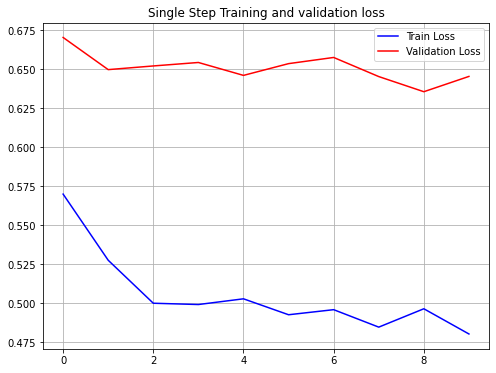

In [38]:
## plot train test loss 

def plot_loss(history , title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss , 'b' , label = 'Train Loss')
  plt.plot(epochs, val_loss , 'r' , label = 'Validation Loss')
  plt.title(title)
  plt.legend()
  plt.grid()
  plt.show()

plot_loss(single_step_model_history , 'Single Step Training and validation loss')

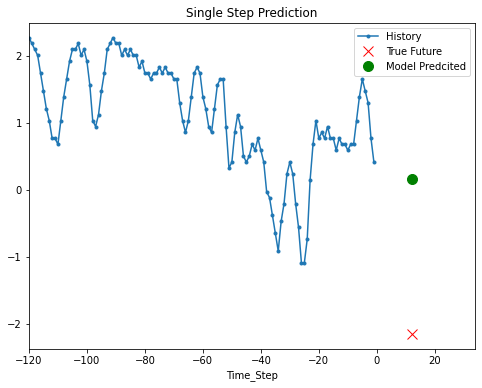

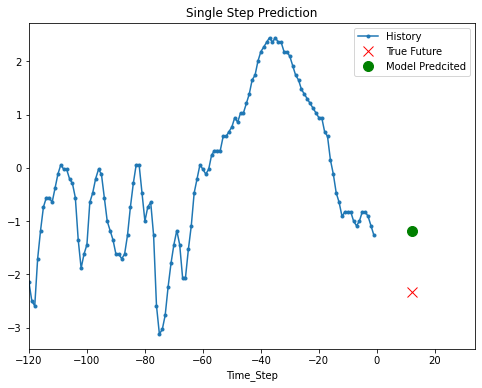

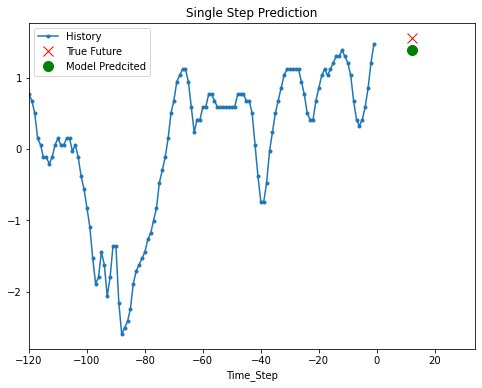

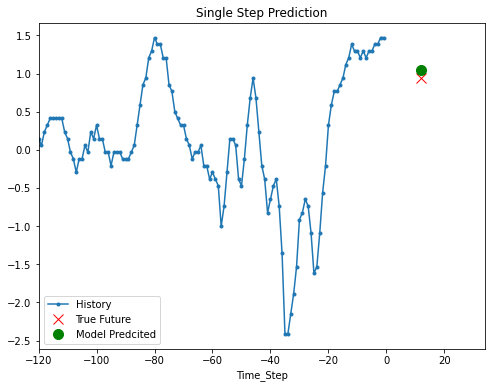

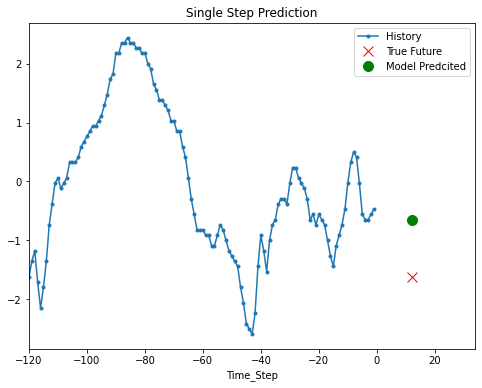

In [39]:
# plot time series and predicted values

for x, y in val_ss.take(5):
  plot = plot_time_series([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

Multi-variate & multi-step forecasting -> Generate multiple future values of temperature

In [40]:
future_target = 72 # 72 future values
x_train_multi, y_train_multi = mutlivariate_data(dataset, dataset[:, 1], 0,
                                                 train_split, history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = mutlivariate_data(dataset, dataset[:, 1],
                                             train_split, None, history,
                                             future_target, STEP)

print(x_train_multi.shape)
print(y_train_multi.shape)

(119280, 120, 3)
(119280, 72)


In [41]:
# TF DATASET

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

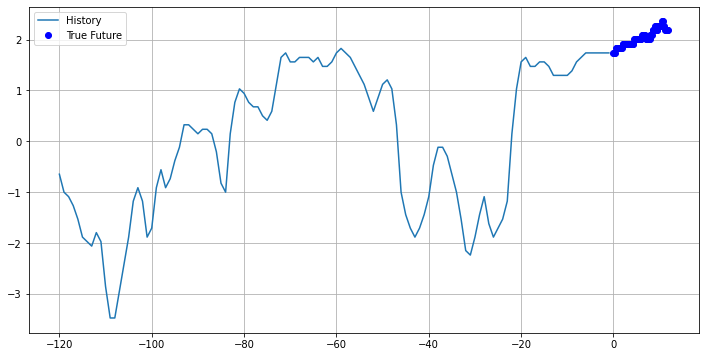

In [42]:
#plotting function
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.grid()
  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()
  


for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

In [43]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72)) # for 72 outputs

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS, steps_per_epoch=steps, validation_data=val_data_multi, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 30s 132ms/step - loss: 2429166.5000 - val_loss: 72.4516
Epoch 2/10
200/200 [==============================] - 27s 135ms/step - loss: 135.0691 - val_loss: 0.9221
Epoch 3/10
200/200 [==============================] - 27s 137ms/step - loss: 0.6604 - val_loss: 0.7372
Epoch 4/10
200/200 [==============================] - 28s 139ms/step - loss: 0.6099 - val_loss: 0.7057
Epoch 5/10
200/200 [==============================] - 30s 148ms/step - loss: 0.5669 - val_loss: 0.6893
Epoch 6/10
200/200 [==============================] - 29s 144ms/step - loss: 0.5280 - val_loss: 0.6746
Epoch 7/10
200/200 [==============================] - 29s 146ms/step - loss: 0.5300 - val_loss: 0.6660
Epoch 8/10
200/200 [==============================] - 30s 148ms/step - loss: 0.5078 - val_loss: 0.6746
Epoch 9/10
200/200 [==============================] - 30s 151ms/step - loss: 0.5169 - val_loss: 0.6638
Epoch 10/10
200/200 [==============================] - 31s 154ms

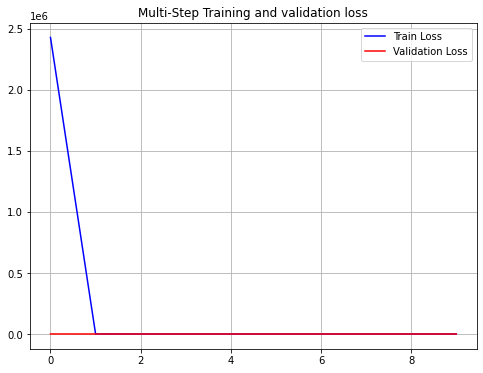

In [44]:
plot_loss(multi_step_history, 'Multi-Step Training and validation loss')

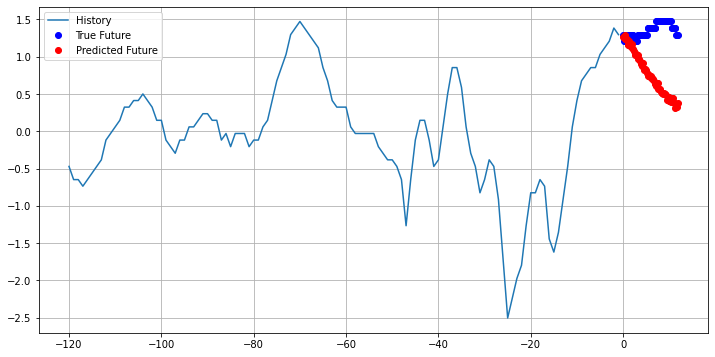

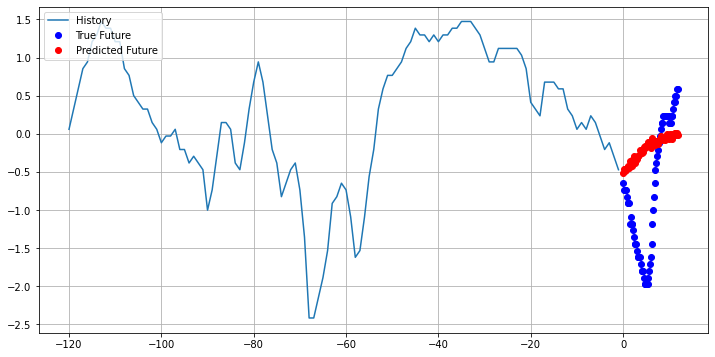

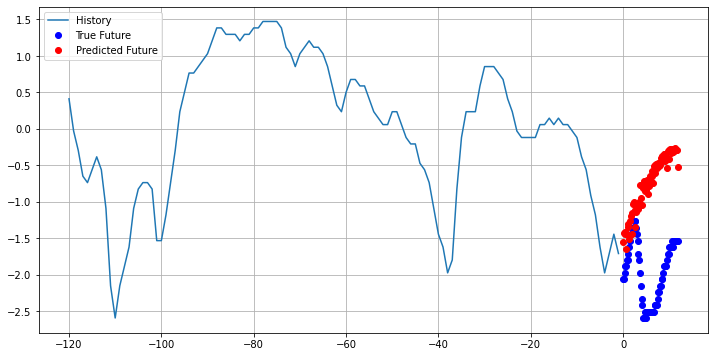

In [45]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])